## Задание 2.
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests
from urllib.parse import urlencode
import json

from tqdm.auto import tqdm

Для начала проанализируем датафрейм

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'


final_url = base_url + urlencode(dict(public_key =public_key))
response = requests.get(final_url)
url = response.json()['href']



In [10]:
response

<Response [200]>

In [11]:
df = pd.read_csv(url, sep = ';')

In [12]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [14]:
df.user_id.nunique()

404770

In [15]:
groups = df.groupby('testgroup', as_index = False).agg({'revenue': 'mean', 'user_id':'count'})
groups

,testgroup,revenue,user_id
0,a,25.413720,202103
1,b,26.751287,202667


In [16]:
#Средняя сумма выручки и количество платящих пользователей по группам
pay = df.loc[df.revenue >0].groupby('testgroup', as_index = False).agg({'revenue': 'mean', 'user_id':'count'})
pay

,testgroup,revenue,user_id
0,a,2663.998444,1928
1,b,3003.658172,1805


In [17]:
# процент платящих по группам
pay['cr'] = (pay.user_id/groups.user_id*100).round(2)
pay

,testgroup,revenue,user_id,cr
0,a,2663.998444,1928,0.95
1,b,3003.658172,1805,0.89


<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

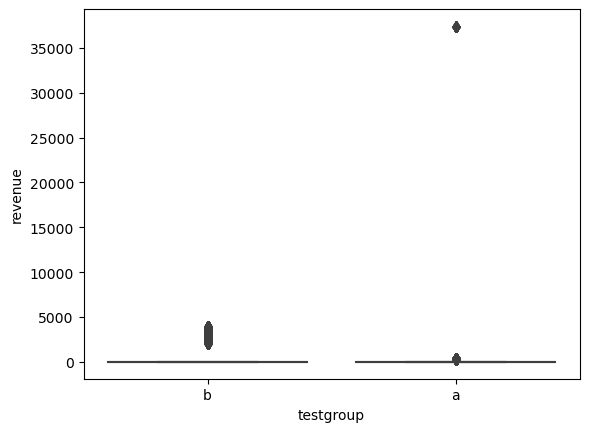

In [18]:
# Посмотрим на выбросы
sns.boxplot(data =df, x = 'testgroup', y = 'revenue')

По таким графикам можно сказать, что большинство пользователей не пользовались акционными предложениями. Отфильтруем только платящих и попробуем еще раз

In [19]:
paying_users = df.loc[df.revenue > 0]

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

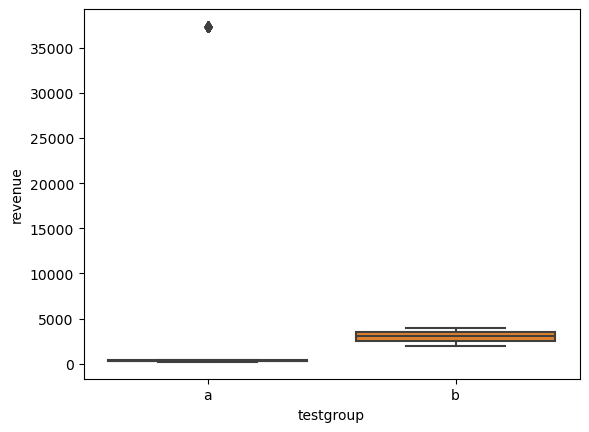

In [20]:
sns.boxplot(data =paying_users, x = 'testgroup', y = 'revenue')

Также видны сильные выбросы в обоих группах.
Выделим тестовую и контрольную группы. Проверив размеры получившихся датафреймов, количество строк с ненулевыми revenue и посчитав ARPU  убедимся, что все так как и указано в условии задачи. 

In [21]:
control = df.loc[df.testgroup == 'a'].drop(columns = 'testgroup')
test = df.loc[df.testgroup == 'b'].drop(columns = 'testgroup')

print(f'размер контрольной группы {control.shape[0]} пользователей')
print(f'размер тестовой группы {test.shape[0]} пользователей')
print(f'количество платящих пользователей в контрольной группе {control.loc[control.revenue != 0].shape[0]}')
print(f'количество платящих пользователей в тестовой группе {test.loc[test.revenue != 0].shape[0]}')

control_arpu = control.revenue.sum()/control.shape[0]
test_arpu = test.revenue.sum()/test.shape[0]
diff = (test_arpu - control_arpu)/test_arpu*100

print(f'ARPU в тестовой группе выше на {diff}, чем в контрольной')

размер контрольной группы 202103 пользователей
размер тестовой группы 202667 пользователей
количество платящих пользователей в контрольной группе 1928
количество платящих пользователей в тестовой группе 1805
ARPU в тестовой группе выше на 5.00000944496214, чем в контрольной


Посмотрим на распределение revenue в контрольной и тестовой группах в общем, и отдельно для платящих пользователей. Посмотрим на описательную статистику

In [22]:
control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [23]:
test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


 Рассмотрим  по группам и отдельно по платящим пользователям

Text(0.5, 1.0, 'Тестовая группа, платящие пользователи')

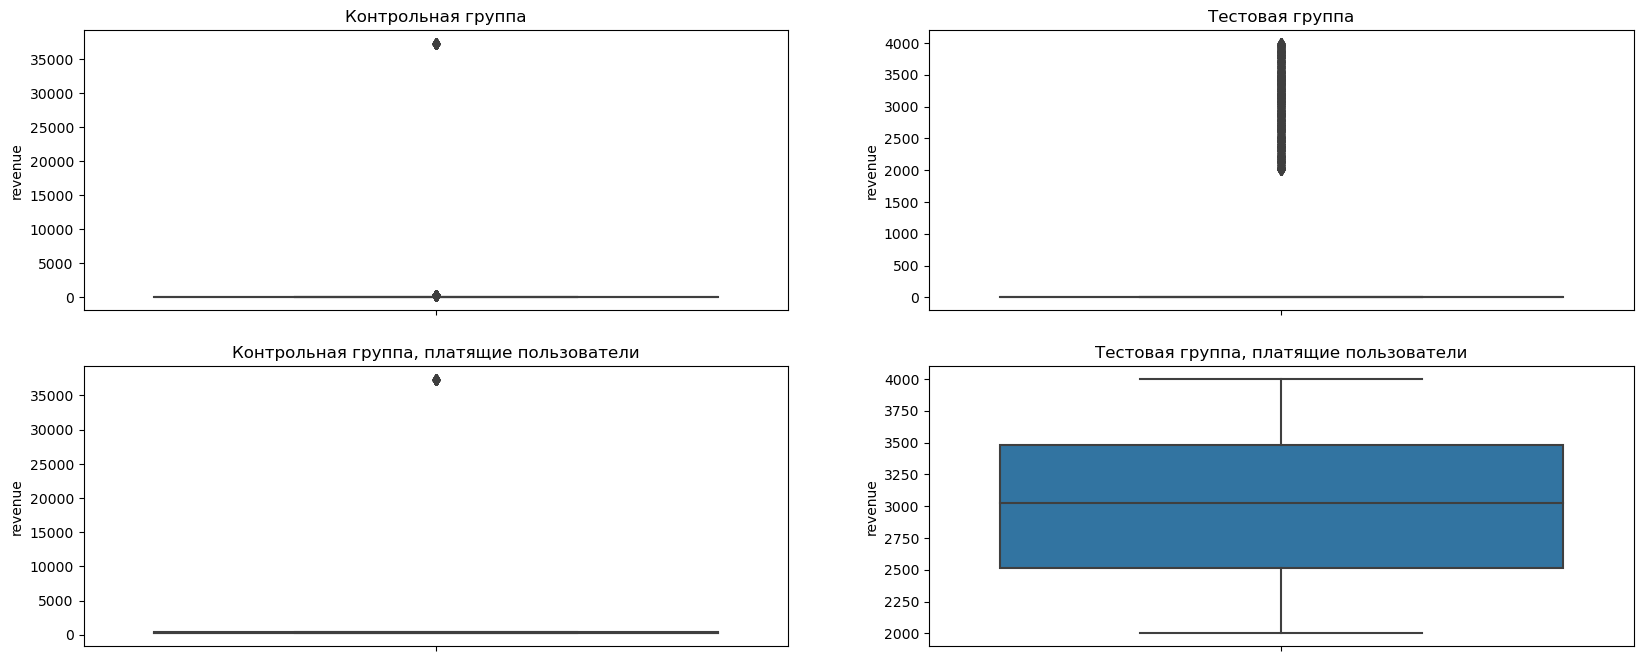

In [24]:
plt.figure(figsize = (20,8))
plt.subplot (2, 2, 1)
sns.boxplot(data =control,  y = 'revenue')
plt.title ("Контрольная группа")

plt.subplot (2, 2, 2)
sns.boxplot(data = test,  y = 'revenue')
plt.title ("Тестовая группа")

plt.subplot (2, 2, 3)
sns.boxplot(data = control.loc[control.revenue > 0],  y = 'revenue')
plt.title ("Контрольная группа, платящие пользователи" )

plt.subplot (2, 2, 4)
sns.boxplot(data =test.loc[test.revenue > 0],  y = 'revenue')
plt.title ("Тестовая группа, платящие пользователи" )

C:\Users\pazun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pazun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pazun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0.5, 1.0, 'Тестовая группа, платящие пользователи')

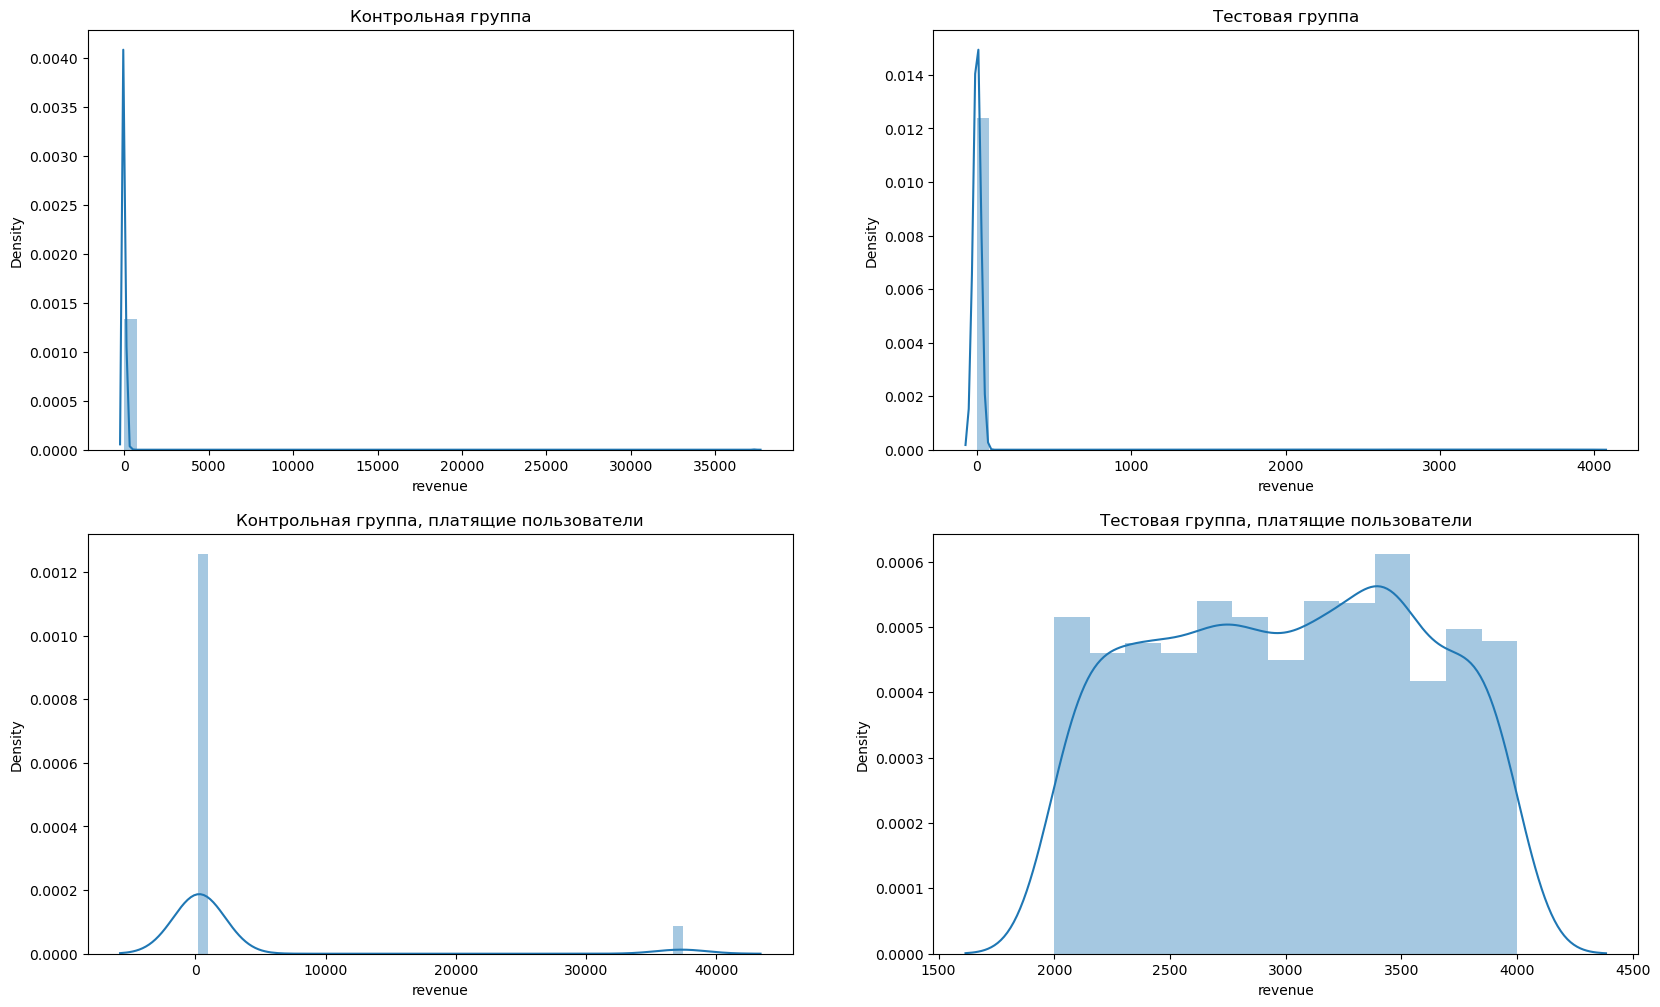

In [25]:
plt.figure(figsize = (20,12))

plt.subplot (2, 2, 1)
sns.distplot(control.revenue)
plt.title ("Контрольная группа")


plt.subplot (2, 2, 2)
sns.distplot(test.revenue)
plt.title ("Тестовая группа")

plt.subplot (2, 2, 3)
sns.distplot(control.loc[control.revenue > 0].revenue)
plt.title ("Контрольная группа, платящие пользователи")


plt.subplot (2, 2, 4)
sns.distplot(test.loc[test.revenue > 0].revenue)
plt.title ("Тестовая группа, платящие пользователи" )

Рассмотрим подробнее контрольную группу платящих пользователей, а конкретно пиковые значения

C:\Users\pazun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pazun\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Контрольная группа - большие суммы')

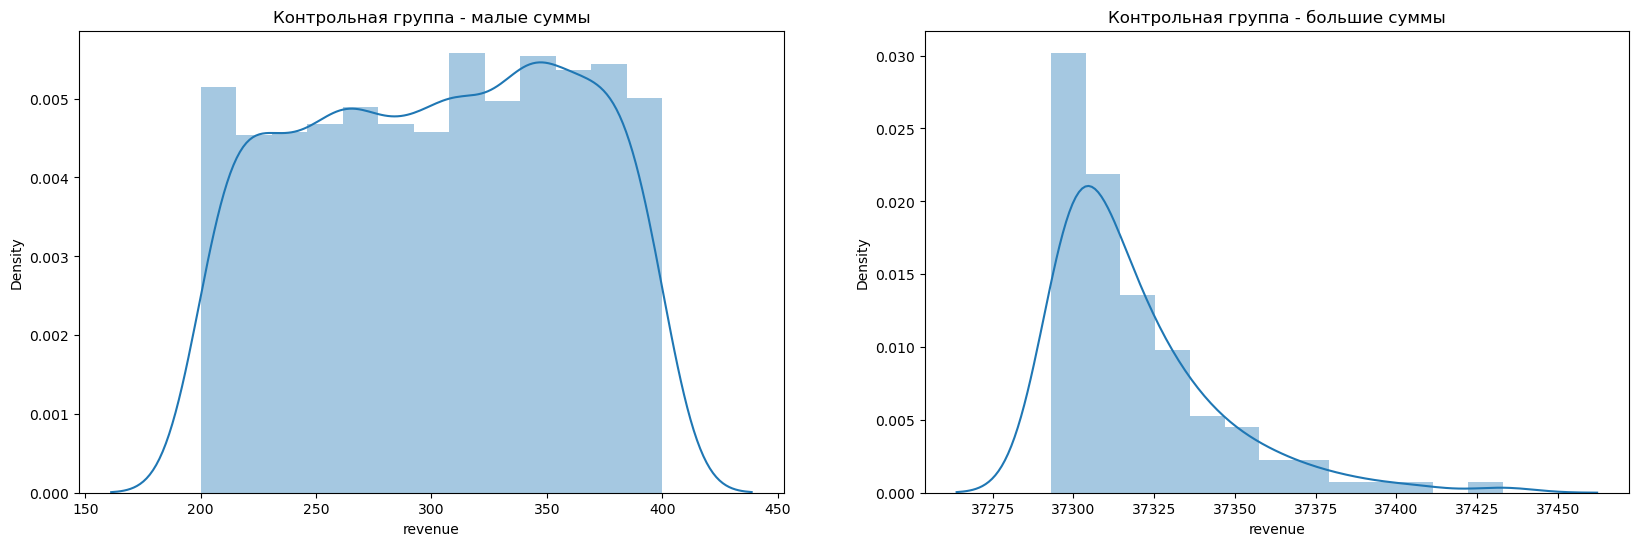

In [26]:
plt.figure(figsize = (20,6))

plt.subplot (1, 2, 1)
sns.distplot(control.loc[(control.revenue > 0) & (control.revenue < 1000)].revenue)
plt.title ("Контрольная группа - малые суммы")

plt.subplot (1, 2, 2)
sns.distplot(control.loc[(control.revenue > 1000) & (control.revenue < 40000)].revenue)
plt.title ("Контрольная группа - большие суммы")



### Выводы по предварительному анализу данных:

В датафрейме 404770 строк, нет пропусков, нет дубликатов, все user_id уникальны. Количество данных по группам распределено более менее равномерно. Средняя выручка в группе "а" больше чем в группе "b". Платящих пользователей около 0,91 % от всей выборки. 

В данных присутствуют существенные выбросы, распределение выручки в группах не является нормальным (далее мы проверим это).
В контрольной группе выбросы гораздо сильней чем в тестовой. Даже отфильтровав неплатящих пользователей мы видим, что есть два пика - 200-400  - малые суммы, и в районе 37000 - большие суммы. Очевидно в этой группе пользователям предлагались наборы с разным уровнем стоимости.
В тестовой группе все платящие пользователи  относительно равномерно распределились в диапазоне 2000 - 4000.

В датафрейме присутствуют  данные о номерах пользователей и выручке с покупок по акциям. Из этих данных мы можем извлечь следующие метрики:

ARPU - средний доход с пользователя приложения;

ARPPU - средний доход с платящего пользователя;

CR - конверсия пользователей в платящих пользователей.


Поскольку прибыль приносит лишь 1 % пользователей, а наша задача состоит в том, чтобы выяснить имеются ли различия в  выручке, то наиболее актуальным будет рассмотрение метрики ARPPU, чтобы выяснить, имеются ли стстистически значимые различия в группах платящих пользователей. Также полезным будет протестиhвать различия в CR.

## Проанализируем ARPPU
Сформулируем гипотезы:

нулевая гипотеза - ARPPU не изменилось(разница в контрольной и тестовой группах не являются статистически значимыми)

альтернативная гипотеза - разница в ARPPU контрольной и тестовой группа статистически значима.

Дя начала просто посчитаем ARPPU для обеих групп:



In [27]:
pay_control = control.loc[(control.revenue > 0)]
pay_test = test.loc[(test.revenue > 0)]

In [28]:
control_arppu = pay_control.revenue.sum()/pay_control.shape[0]
control_arppu

2663.9984439834025

In [29]:
test_arppu = pay_test.revenue.sum()/pay_test.shape[0]
test_arppu

3003.6581717451522

In [30]:
diff_arppu = (test_arppu - control_arppu)/test_arppu*100
diff_arppu

11.308201810607645

ARPPU  в тестовой группе выше на 11.3%

Проверим распределение данных на нормальность. Предположение: данные распределены нормально

In [31]:
print(ss.normaltest(pay_control))
print(ss.normaltest(pay_test))

NormaltestResult(statistic=array([1524.2445768 , 1394.94578431]), pvalue=array([0.00000000e+000, 1.23416055e-303]))
NormaltestResult(statistic=array([1093.11572274, 1068.86000844]), pvalue=array([4.29473890e-238, 7.94324949e-233]))


Вероятность того, что наше предположение верно практически равна 0. Значит данные распределены ненормально

Проверим данные на гомогенность критерием Бартлета

In [32]:
ss.bartlett(control.revenue, test.revenue)

BartlettResult(statistic=228631.09533590218, pvalue=0.0)

Таким образом, данные не являются гомогенными. Мы не сможем воспользоваться Т-критерием Стьюдента, чтобы проанализировать различия.
Попробуем воспользоваться бутстрапом.
Напишем функцию, которая позволит проверить нулевую гипотезу о 
том, что средняя выручка платящего пользователя в тестовой и контрольной группах не отличаются. Уровень значимости примем 0.95

In [33]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

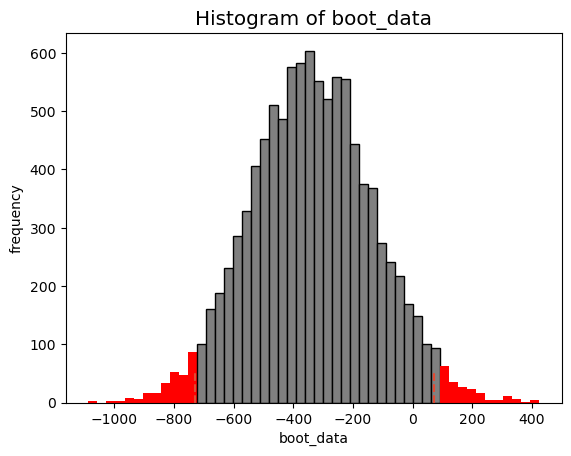

In [34]:
booted_data = get_bootstrap(pay_control.revenue, pay_test.revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [35]:
booted_data["p_value"] # альфа

0.10259919326289249

In [36]:
booted_data["quants"] # ДИ

,0
0.025,-730.748755
0.975,73.536398




### Вывод касаемо различий в ARPPU

Рассмотрев представленные данные и проведя bootstrap тест средних мы можем сказать, что различия в контрольной и тесовой группе не являются статистически значимыми. Это означает, что, на основании полученных выборок и проведенного теста мы не можем утверждать, что одна группа имеет ARPPU выше чем другая

## Convertion rate
 Ранее мы уже считали CR


In [37]:
pay

,testgroup,revenue,user_id,cr
0,a,2663.998444,1928,0.95
1,b,3003.658172,1805,0.89


Итак, в контрольной группе(а) конверсия в платящего пользователя выше чем в тестовой группе (b).

Сформулируем гипотезы:

Нулевая гипотеза - нет статистически значимых различий между CR в контрольной и тестовой группе

Альтернативная гипотеза - различия в СR контрольно и тестовой группе статистически значимы, конверсия в контрольной группе выше чем в тестовой.

Для тестирования используем критерий Хи-квадрат  согласия Пирсона, поскольку мы имеем категориальные переменные

Создадим таблицу сопряженности, где будут платившие и неплатившие пользователи, в разбивке по группам


In [43]:
chi_test = df
chi_test['users_paid'] = np.where(chi_test.revenue > 0, 1, 0)
chi_test = chi_test.groupby('testgroup').agg({'users_paid':'sum', 'user_id':'count'})
chi_test['not_paid'] = chi_test.user_id-chi_test.users_paid

In [44]:
conv = pd.crosstab(df.users_paid,df.testgroup)
conv

testgroup,a,b
users_paid,,
0,200175,200862
1,1928,1805


Запустим тест

In [45]:
res = ss.chi2_contingency(conv)
chi2_p_value = res[1]
chi2_statistic = res[0]

In [46]:
print(chi2_p_value)
print(chi2_statistic)

0.03647561892312613
4.374729521260405


### Вывод по convertion rate
При 5% уровне значимости мы получили p_value = 0,036%, а значит мы отклоняем нулевую гипотезу от равенстве конверсий в контрольной и тестовой группе. Принимается альтернативная гипотеза о том что конверсия в контрольной группе выше чем в тестовой

## Ответ на задачу:
В ходе анализа данных мы выяснили, что нет стстистически значимых отличий между средним доходом с платящего пользователя в контрольной и тестовой группах. Одновременно с этим существуют статистически значчимые отличия в конверсии в платящего пользователя в контрольной иитестовой группах. Конверсия в контрольной группе выше. Значит набор предложений в контрольной группе лучше. При равных затратах на акцию, он принесет больше прибыли

